In [1]:
import tensorflow as tf
from common.tf_util import get_session
from common.cmd_util import make_vec_env
from common.policies import build_policy
from ppo2.runner import Runner
import gym, os
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from ppo2.model import Model
from common.ah_env import in_hull
import pickle

def build_env(env_id,seed,with_obs=0,obs_idx=20,ah_with_goal_loc=0,ah_goal_loc_idx=8,ah_with_reach_goal=1,ctrl_rwd=1,ctrl_rwd_coef=1,goal_height=1.0,env_type='corl',with_obs_end=1,sparse=0,obs_pen=1e6,final_rwd=0.,horizon=2000):
    config = tf.ConfigProto(allow_soft_placement=True,intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
    config.gpu_options.allow_growth = True
    get_session(config=config)
    env = make_vec_env(env_id, env_type, horizon, with_obs, with_obs_end, obs_idx, obs_pen, sparse, ah_with_goal_loc, ah_goal_loc_idx, ah_with_reach_goal, ctrl_rwd, final_rwd, ctrl_rwd_coef, goal_height, 1, seed, reward_scale=1.0, flatten_dict_observations=True)
    return env

def prepare(env_id,seed,horizon,with_obs,with_obs_end,obs_idx,obs_pen,sparse,ah_with_goal_loc,ah_goal_loc_idx,ah_with_reach_goal,ctrl_rwd,final_rwd,load_path,model):
    env=build_env(env_id,seed=seed,with_obs=with_obs,obs_idx=obs_idx,ah_with_goal_loc=ah_with_goal_loc,ah_goal_loc_idx=ah_goal_loc_idx,ah_with_reach_goal=ah_with_reach_goal,ctrl_rwd=ctrl_rwd,with_obs_end=with_obs_end,sparse=sparse,obs_pen=obs_pen,final_rwd=final_rwd,horizon=horizon)
    model.load(load_path)
    runner = Runner(env=env, model=model, nsteps=2048, gamma=0.99, lam=0.95)
    return model,runner

def eval_ah(set_path,filesave_pre,run_idx,plan_path,with_obs,goal_loc,big_goal_radius,obs_dist,H1,H2,H1D,H2D,Obs=None):
    initial_state=plan_path[0,:2]
    fig, ax = plt.subplots(figsize=(8,3.5))
    H = np.concatenate((np.array(H1)[:,:], H2), axis=0)
    pgon = plt.Polygon(H, color='y', alpha=1, zorder=0)
    ax.add_patch(pgon)
    goal_plan = plt.Circle((goal_loc[0], goal_loc[1]), big_goal_radius, color='m')
    ax.add_artist(goal_plan)
    plt.text(goal_loc[0]-3.5, goal_loc[1]-2.5, str(run_idx), fontsize=20)
    if with_obs:
        for o in Obs:
            if in_hull(np.array(o[:2]),H1D,H2D):
                if np.linalg.norm(goal_loc-o[:2])>big_goal_radius+obs_dist:
                    obstacle = plt.Circle(o[:2], obs_dist, color=[0.4,0.4,0.4])#, zorder=10)
                    ax.add_artist(obstacle)
    plt.plot(initial_state[0], initial_state[1], 'ok', markersize=16, color ='r')
    plt.plot(plan_path[:,0],plan_path[:,1],'-k',label='Planned Path')
    plt.ylim([60, 140])
    plt.xlabel('x')
    plt.ylabel('y')
    #plt.legend()
    plt.savefig(set_path+filesave_pre+'.png',dpi=200)
    plt.show()
    return plan_path

In [2]:
with_obs=1
obs_idx=20
ah_with_goal_loc=1
ah_with_reach_goal=1
ctrl_rwd=1
with_obs_end=1
sparse=0
horizon=2000
    
model_fn = Model
env_id='ah'
env=build_env(env_id,0,with_obs,obs_idx,ah_with_goal_loc,15,ah_with_reach_goal,ctrl_rwd,with_obs_end=with_obs_end,sparse=sparse,obs_pen=1e6,final_rwd=0)
ob_space = env.observation_space
ac_space = env.action_space
policy = build_policy(env, 'mlp', value_network='copy')
model = model_fn(policy=policy, env_type='corl', ob_space=ob_space, ac_space=ac_space, nbatch_act=1, nbatch_train=64,ent_coef=0.0, vf_coef=0.5,max_grad_norm=0.5, comm=None, mpi_rank_weight=1)

Logging to /var/folders/h2/zl4wv27s7_l5c_09wvwjdl_80000gn/T/openai-2020-06-28-19-39-15-053281


/usr/local/lib/python3.6/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or se

aaa
aaa
aaa
OK!
aaa
aaa
aaa
-55363.523023


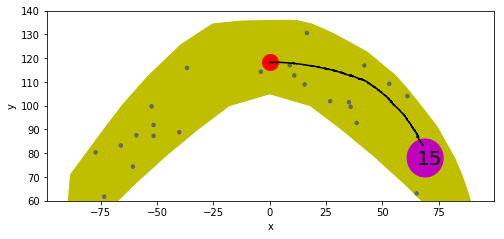

1298
OK!
OK!
OK!
-23669.739533


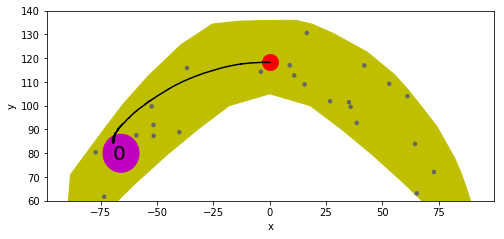

946
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
OK!
-13668.867607


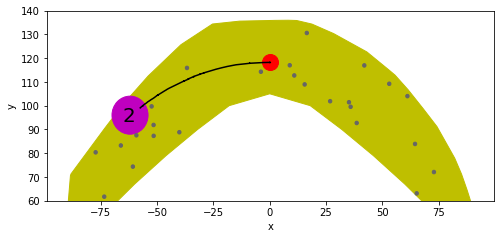

384
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
OK!
aaa
aaa
aaa
aaa
aaa
aaa
OK!
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
-23413.502276


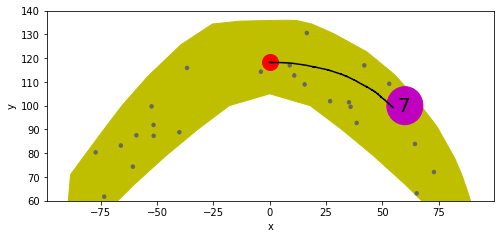

694
OK!
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
OK!
OK!
aaa
-21256.994733


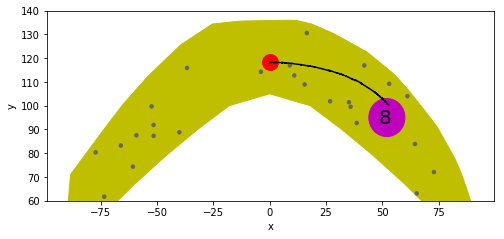

751


In [3]:
#with_goal_loc with_obs seed 1 best; no_goal_loc with_obs seed 0 best
#for obs_pen in [1e5]:
for obs_pen in [4e4]:
#for obs_pen in [1e6]:
    final_rwd=0.
    for ah_goal_loc_idx in [15,0,2,7,8]:
        folder_suf=''
        
        if ah_with_reach_goal:
            folder_suf+='_withreachgoal'
        else:
            folder_suf+='_noreachgoal'
            
        if not sparse:
            if ctrl_rwd:
                folder_suf+='_ctrl1'
            else:
                folder_suf+='_noctrl'
        else:
            folder_suf+='_sparse'
        
        res_folder='../beliefspaceplanning/rollout_node/set/'

        if obs_idx==14:
            model_pre='no_goal_loc'
            final_ah_goal_loc_idx=0
            big_goal_radius=5.
            obs_dist=0.5
            res_folder+='set21c_policy_nogoalloc'
            eval_steps=horizon
            
        else:
            final_ah_goal_loc_idx=ah_goal_loc_idx
            big_goal_radius=8.
            obs_dist=0.75
            if ah_with_goal_loc:
                eval_steps=horizon*2
                model_pre='with_goal_loc'
                res_folder+='set20c_policy_withgoalloc'
            else:
                eval_steps=horizon
                model_pre='no_goal_loc_'+str(ah_goal_loc_idx)
                res_folder+='set20c_policy_nogoalloc'
        
        if with_obs:
            res_folder+='_OBS/'
            model_pre+='_withobs_numsteps_7_lr_0.1'
            with open('./obs_'+str(obs_idx)+'.pkl', 'rb') as f: 
                Obs = pickle.load(f,encoding='latin')
        else:
            res_folder+='/'
            model_pre+='_noobs_numsteps_7_lr_0.1'
            Obs=None

        if with_obs_end:
            suf_suf=''
        else:
            suf_suf='_noobsend'
        if obs_pen!=1e6:
            suf_suf+='_pen'+str(int(obs_pen))
        if final_rwd!=0.:
            suf_suf+='_frwd'+str(int(final_rwd))
        if horizon!=2000:
            suf_suf+='_h'+str(horizon)


        for seed in [1]:
            load_path='./ppo2_results/models/test_ah'+folder_suf+'/numsteps_7_lr_0.1/obs_idx_'+str(obs_idx)+'/'+model_pre+folder_suf+suf_suf+'_seed_'+str(seed)
            model,runner=prepare(env_id,seed,horizon,with_obs,with_obs_end,obs_idx,obs_pen,sparse,ah_with_goal_loc,ah_goal_loc_idx,ah_with_reach_goal,ctrl_rwd,final_rwd,load_path,model)
            for run_idx in [final_ah_goal_loc_idx]:
                obs, returns, masks, actions, values, neglogpacs, states, epinfos, final_obs = runner.run(do_eval=True,num_eval_eps=1,compare=True,compare_ah_idx=run_idx,reacher_sd=run_idx,acrobot_sd=run_idx,eval_steps=eval_steps)
                do_eval_epinfobuf=deque(maxlen=10000)
                do_eval_epinfobuf.extend(epinfos)
                start_idx=0
                found=False
                rwd_ls,idx_ls=[],[]
                for j in range(len(epinfos)):
                    if ah_goal_loc_idx==15 or ah_goal_loc_idx==0:
                        cond=-6e4
                        #cond=-obs_pen
                    else:
                        cond=-obs_pen
                    if np.linalg.norm(final_obs[j][0,:2]-runner.env.goal_loc)<=0.6875*big_goal_radius:
                        rwd_ls.append(epinfos[j]['r'])
                        idx_ls.append(j)
                    '''
                    if epinfos[j]['r']>cond:
                        print(epinfos[j]['r'])
                        observ=obs[start_idx:start_idx+do_eval_epinfobuf[j]['l'],:]
                        actions=actions[start_idx:start_idx+do_eval_epinfobuf[j]['l'],:]
                        observ=np.concatenate([observ,final_obs[j]],axis=0)
                        found=True
                        break
                    start_idx+=epinfos[j]['l']
                    '''
                if len(rwd_ls)!=0:
                    j=np.argmax(rwd_ls)
                    start_idx=0
                    print(rwd_ls[j])
                    found=True
                    for i in range(idx_ls[j]):
                        start_idx+=epinfos[i]['l']
                    observ=obs[start_idx:start_idx+do_eval_epinfobuf[idx_ls[j]]['l'],:]
                    actions=actions[start_idx:start_idx+do_eval_epinfobuf[idx_ls[j]]['l'],:]
                    observ=np.concatenate([observ,final_obs[idx_ls[j]]],axis=0)
                
                
                if found:
                    if not (np.linalg.norm(observ[:,:2]-runner.env.goal_loc,axis=1)<=big_goal_radius).any():
                        print("No reach goal within horizon")
                    else:
                        if np.linalg.norm(observ[-1,:2]-runner.env.goal_loc)>0.6875*big_goal_radius:
                            print("Only reach goal within big goal radius")
                            idxx=np.argmin(np.linalg.norm(observ[:,:2]-runner.env.goal_loc,axis=1))
                            observ=observ[:idxx+1,:]
                            actions=actions[:idxx+1,:]
                        filesave_pre='policy_OBS'+'_seed'+str(seed)+'_goal'+str(run_idx)+'_run0'    
                        if with_obs:
                            filesave_pre+='_withOBS_numsteps_7_lr_0.1'
                        else:
                            filesave_pre+='_noOBS_numsteps_7_lr_0.1'
                        filesave_pre+=folder_suf
                        filesave_pre+=suf_suf
                        if obs_idx==20:
                            if ah_with_goal_loc:
                                filesave_pre+='_withgoalloc'
                            else:
                                filesave_pre+='_nogoalloc'
                            filesave_pre+='_obs0.75'
                        else:
                            filesave_pre+='_obs0.5'

                        if not os.path.exists(res_folder):
                            os.makedirs(res_folder)
                        actions=np.clip(actions,env.action_space.low,env.action_space.high)
                        np.savetxt(os.path.abspath(res_folder+filesave_pre+'_traj.txt'),observ[:,:4], fmt='%.20f', delimiter=',')
                        np.savetxt(os.path.abspath(res_folder+filesave_pre+'_plan.txt'),actions, fmt='%.20f', delimiter=',')
                        if runner.env.env_name=='ah':
                            eval_ah(res_folder,filesave_pre,run_idx,observ,with_obs,runner.env.goal_loc,big_goal_radius,obs_dist,runner.env.H1,runner.env.H2,runner.env.H1D,runner.env.H2D,Obs=Obs)
                            print(actions.shape[0])  
                else:
                    print("No solution")